In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 25

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 25)                275       
                                                                 
Total params: 1345 (5.25 KB)
Trainable params: 1345 (5.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1500,
    batch_size=512,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1500


1/5 [=====>........................] - ETA: 3s - loss: 3.2817 - accuracy: 0.0293
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
5/5 [==============================] - 1s 60ms/step - loss: 3.2755 - accuracy: 0.0307 - val_loss: 3.2380 - val_accuracy: 0.0418
Epoch 2/1500
1/5 [=====>........................] - ETA: 0s - loss: 3.2424 - accuracy: 0.0488
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
5/5 [==============================] - 0s 14ms/step - loss: 3.2419 - accuracy: 0.0465 - val_loss: 3.2108 - val_accuracy: 0.0501
Epoch 3/1500
1/5 [=====>........................] - ETA: 0s - loss: 3.2278 - accuracy: 0.0488
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
5/5 [==============================] - 0s 14ms/step - loss: 3.2228 - accuracy: 0.0535 - val_loss: 3.1823 - val_accuracy: 0.0891
Epoch 4/1500
1/5 [=====>........................] - ETA: 0s - loss: 3.2043 - accuracy: 0.0684
Epoch 4: s

D:\GodotProjects\tddd57-labs\hand-gesture-recognition-mediapipe\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 0s 15ms/step - loss: 3.1989 - accuracy: 0.0623 - val_loss: 3.1556 - val_accuracy: 0.1170
Epoch 5/1500
1/5 [=====>........................] - ETA: 0s - loss: 3.1882 - accuracy: 0.0566
Epoch 5: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
5/5 [==============================] - 0s 14ms/step - loss: 3.1837 - accuracy: 0.0595 - val_loss: 3.1330 - val_accuracy: 0.1156
Epoch 6/1500
1/5 [=====>........................] - ETA: 0s - loss: 3.1837 - accuracy: 0.0723
Epoch 6: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
5/5 [==============================] - 0s 14ms/step - loss: 3.1683 - accuracy: 0.0697 - val_loss: 3.1139 - val_accuracy: 0.1100
Epoch 7/1500
1/5 [=====>........................] - ETA: 0s - loss: 3.1597 - accuracy: 0.0586
Epoch 7: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
5/5 [==============================] - 0s 14ms/step - loss: 3.1480 - accuracy: 0.0772 - val_loss: 3.0965 -

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

6/6 [==============================] - 0s 2ms/step - loss: 0.9529 - accuracy: 0.7270


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 76ms/step
[8.33009407e-02 5.02841749e-06 1.67098086e-04 5.57251587e-06
 3.09448272e-01 2.51834945e-06 3.71764600e-01 7.90242944e-03
 3.08836140e-02 7.25466316e-06 1.12264999e-04 9.69565380e-03
 1.01674758e-08 2.00409175e-10 1.40782058e-01 1.07758915e-07
 4.00026813e-02 1.52769431e-07 5.80505608e-03 1.29665622e-07
 1.69324166e-09 5.60448488e-09 1.92320897e-08 8.04142083e-12
 1.14486000e-04]
6


# Confusion matrix

23/23 [==============================] - 0s 841us/step


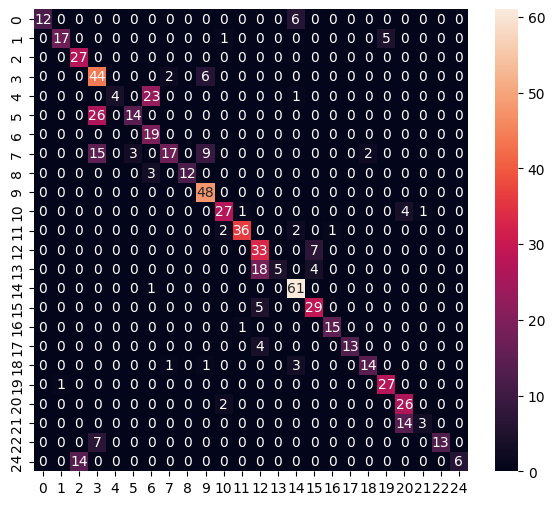

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        18
           1       0.94      0.74      0.83        23
           2       0.66      1.00      0.79        27
           3       0.48      0.85      0.61        52
           4       1.00      0.14      0.25        28
           5       0.82      0.35      0.49        40
           6       0.41      1.00      0.58        19
           7       0.85      0.37      0.52        46
           8       1.00      0.80      0.89        15
           9       0.75      1.00      0.86        48
          10       0.84      0.82      0.83        33
          11       0.95      0.88      0.91        41
          12       0.55      0.82      0.66        40
          13       1.00      0.19      0.31        27
          14       0.84      0.98      0.90        62
          15       0.72      0.85      0.78        34
          16       0.94      0.94      0.94        16
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.savefig("model/keypoint_classifier/current_confusion_matrix.png")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

D:\GodotProjects\tddd57-labs\hand-gesture-recognition-mediapipe\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Albin\AppData\Local\Temp\tmpx6vdyfrh\assets


INFO:tensorflow:Assets written to: C:\Users\Albin\AppData\Local\Temp\tmpx6vdyfrh\assets


7468

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.3300948e-02 5.0284079e-06 1.6709787e-04 5.5725159e-06 3.0944818e-01
 2.5183497e-06 3.7176463e-01 7.9024360e-03 3.0883603e-02 7.2546632e-06
 1.1226478e-04 9.6956473e-03 1.0167437e-08 2.0040840e-10 1.4078221e-01
 1.0775871e-07 4.0002644e-02 1.5276899e-07 5.8050621e-03 1.2966525e-07
 1.6932351e-09 5.6044636e-09 1.9232090e-08 8.0414061e-12 1.1448590e-04]
6
